In [1]:
using DrWatson
@quickactivate "TriangularHubbard"

using DataStructures
using CodecXz
using SQLite
using DBInterface
using DataFrames
using Printf
using LsqFit
using ProgressMeter
using Quadmath
using Statistics
using ProgressMeter

using PyPlot
using PyCall
mpl = pyimport("matplotlib")
sns = pyimport("seaborn")

  Activating project at `/data/pn1_1/klee/Projects/TriangularHubbard`


PyObject <module 'seaborn' from '/home/klee/.pyenv/versions/conda_jl/lib/python3.7/site-packages/seaborn/__init__.py'>

In [ ]:
PyPlot.rc("axes", labelsize="medium", titlesize="medium")
PyPlot.rc("xtick", labelsize="small")
PyPlot.rc("ytick", labelsize="small")
PyPlot.rc("legend", fontsize="x-small")

#cmap = sns.color_palette("icefire", as_cmap=true)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=true)
# markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"];
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
;

In [4]:
n_sites = 9
shape_str = "(3,0)x(0,3)"
t = 1.0
U = 20.0

20.0

In [5]:
sectors_filepath = datadir("curie", shape_str, "sectors.sqlite3")
isfile(sectors_filepath)

true

In [9]:
conn = DBInterface.connect(SQLite.DB, sectors_filepath)
df = DataFrame(
    DBInterface.execute(conn, """
        SELECT nup, ndn, temperature, partition
        FROM dense_results
        INNER JOIN sectors
        ON dense_results.idx = sectors.idx
        WHERE hopping=? AND interaction=?
    """, (t, U))
)
# df2 = DataFrame(
#     DBInterface.execute(conn, """
#         SELECT nup, ndn, temperature, partition
#         FROM sparse_results_collection
#         INNER JOIN sectors
#         ON sparse_results.idx = sectors.idx
#         WHERE hopping=? AND interaction=?
#     """, (t, U))
# )
DBInterface.close!(conn)

In [11]:
df[:, :Sz] = 0.5*(df[:, :nup] - df[:, :ndn])
df[:, :charge] = df[:, :nup] + df[:, :ndn]
unique(sort(df[:, :Sz]))
n_list = unique(df[:, :nup] .+ df[:, :ndn])
temperatures = unique(sort(df[:, :temperature]))
;

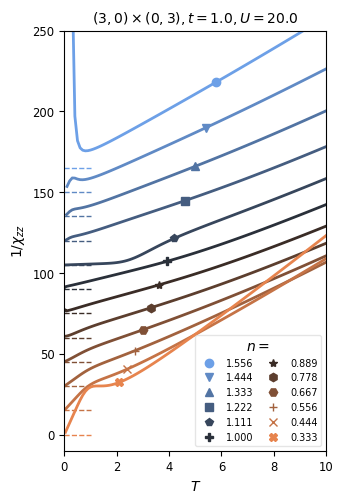

In [218]:
temperatures = unique(sort(df[:, :temperature]))
temperatures = [T for T in temperatures if T >= 0.04]
;

fig = PyPlot.figure(figsize=(3.4, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

# n_list = [5,6,7,8,9,10,11,12,13]
# n_list = [9,10,11,12,13,14,15]
# n_list = n_sites-3:n_sites+3
n_list = n_sites+5:-1:n_sites-6

ymax = 0.0
for (idx, n) in enumerate(n_list)
    if n == 0 || n == 18
        continue
    end
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / (n_sites * T)
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end
    yoffset = 15 * (length(n_list) - idx)
    ys = 1 ./ ys
    
    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys .+ yoffset,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
    let
        xmark = xs[60 - 3*idx]
        ymark = ys[60 - 3*idx] + yoffset
        dxmark = xs[60 - 3*idx] - xs[60 - 3*idx-1]
        dymark = ys[60 - 3*idx] - ys[60 - 3*idx-1]
#         anglemark = atan(dymark, dxmark) * 180 / pi
        ax.plot(xmark, ymark, linestyle="None", marker=markers[idx], label=(@sprintf "%.3f" (n/n_sites)),
            color=color,
            alpha=1.0, markersize=6
        )
#         ax.text(xmark+0.3, ymark, (@sprintf "n=%.3f" (n/n_sites)), fontsize="x-small", color=color, ha="left", va="center",
#             bbox=Dict("boxstyle"=>"square", "pad"=>0, "edgecolor"=>"None", "facecolor"=>"white", "alpha"=>1.0)
#         )
    end
    ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)
    ymax = max(ymax, maximum(ys))
end
ax.set_xlim(0, maximum(temperatures))
ax.set_ylim(-10, 250)
# ax.set_xscale("log")
# ax.set_yscale("log")

ax.legend(title=raw"$n=$", ncol=2, loc=4, framealpha=0.5, columnspacing=1)
ax.set_xlabel(raw"$T$")
ax.set_ylabel(raw"$1/\chi_{zz}$")
#ax.set_title("$(shape_str), t=$t, U=$U")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), t=$t, U=$U\$")

fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)

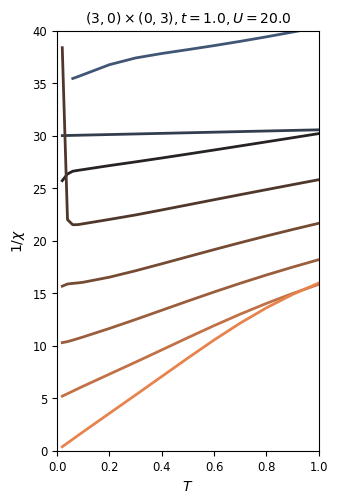

PyObject Text(0.5, 1.0, '$(3,0)\\times(0,3), t=1.0, U=20.0$')

In [148]:
temperatures = unique(sort(df[:, :temperature]))
temperatures = [T for T in temperatures if T >= 0.02]
;

fig = PyPlot.figure(figsize=(3.4, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

ymax = 0.0
for (idx, n) in enumerate(n_list)
    if n == 0 || n == 18
        continue
    end
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / (n_sites * T)
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end
    yoffset = 5.0*(length(n_list) - idx)
    ys = 1 ./ ys
    
    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys .+ yoffset,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
#     ax.plot(xs[60], ys[60] .+ yoffset, linestyle="None", marker=markers[idx], label=(@sprintf "%.3f" (n/n_sites)),
#         color=color,
#         alpha=1.0, markersize=6
#     )
#     ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)
    ymax = max(ymax, maximum(ys))
end
ax.set_xlim(minimum(temperatures), maximum(temperatures))
ax.set_xlim(0, 1)
ax.set_ylim(0, 40)
# ax.set_ylim(-2, ymax + 60)
# ax.set_xscale("log")
# ax.set_yscale("log")

# ax.legend(title=raw"$n=$", loc=4)
ax.set_xlabel(raw"$T$")
ax.set_ylabel(raw"$1/\chi$")
#ax.set_title("$(shape_str), t=$t, U=$U")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), t=$t, U=$U\$")

# fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
# fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)

## Plot Charge

In [277]:
# Plot Charge susceptibility
sdf = df
chemical_potentials = -20:0.1:40
Qg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
χg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
Tg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
μg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
@showprogress for (imu, mu) in enumerate(chemical_potentials)
    for (iT, T) in enumerate(temperatures)
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        z_ = Float128.(ssdf[:, :partition])
        q_ = Float128.(ssdf[:, :charge])
        T_ = Float128(T)
        mu_ = Float128(mu)
        emu_ = exp.(mu_ .* q_ / T_)
        qavg_ = sum(q_ .* z_ .* emu_) ./ sum(z_ .* emu_)
        q2avg_ = sum( q_ .* q_ .* z_ .* emu_) ./ sum(z_ .* emu_)
        Qg[iT, imu] = qavg_
        χg[iT, imu] = (q2avg_ - qavg_.^2) ./ (n_sites * T_)
        Tg[iT, imu] = T
        μg[iT, imu] = mu
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:55


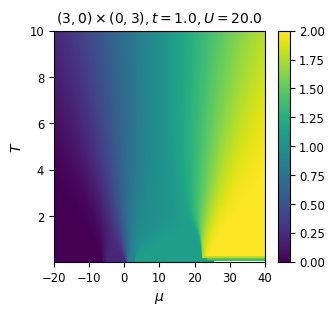

In [333]:
fig = PyPlot.figure(figsize=(3.4, 3))
ax = fig.gca()
# img = ax.imshow(result, extent=[minimum(chemical_potentials), maximum(chemical_potentials), minimum(temperatures), maximum(temperatures)],
# aspect="auto", interpolation="None")
img = ax.pcolor(μg, Tg, Qg ./ n_sites, vmin=0, vmax=2)
ax.set_xlabel(raw"$\mu$")
ax.set_ylabel(raw"$T$")
ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), t=$t, U=$U\$")

fig.colorbar(mappable=img)
# fig.savefig("triangular-hubbard-charge-$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard-charge-$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")


In [281]:
χg[isnan.(χg)] .= 0
χg[abs.(χg) .< 1E-8] .= 0
;

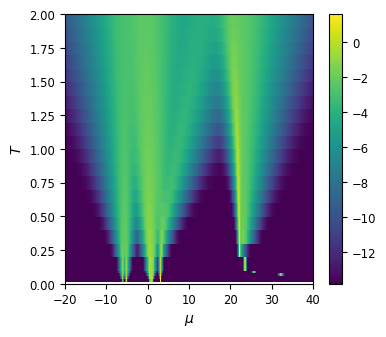

(0.0, 2.0)

In [282]:
fig = PyPlot.figure(figsize=(4, 3.5))
ax = fig.gca()
# img = ax.imshow(result, extent=[minimum(chemical_potentials), maximum(chemical_potentials), minimum(temperatures), maximum(temperatures)],
# aspect="auto", interpolation="None")
img = ax.pcolor(μg, Tg, log.(χg .+ 1E-6))
ax.set_xlabel(raw"$\mu$")
ax.set_ylabel(raw"$T$")
fig.colorbar(mappable=img)
ax.set_ylim(0, 2)

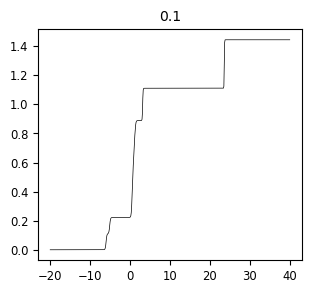

PyObject Text(0.5, 1.0, '0.1')

In [341]:
# for i in 1:size(μg, 1)
fig = PyPlot.figure(figsize=(3.4, 3))
let i = 5
    PyPlot.plot(μg[i, :], Qg[i, :] ./ n_sites, linewidth=0.5, color="black")
    PyPlot.title("$(Tg[i, 1])")
end

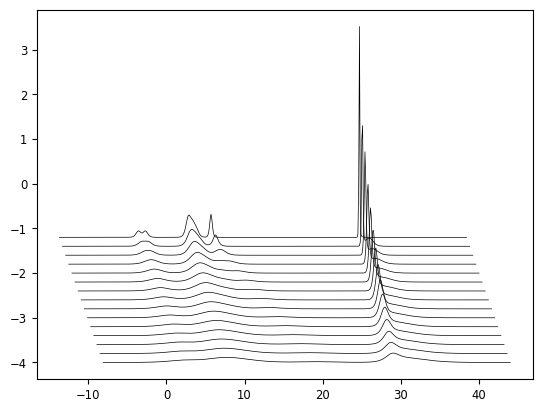

In [323]:
for i in 6:20
    PyPlot.plot(μg[i, 40:end-40] .+ 0.4*i, χg[i, 40:end-40] .- 0.2*i, linewidth=0.5, color="black")
end

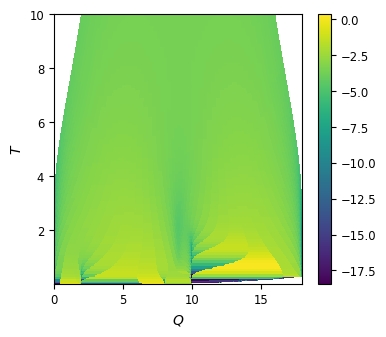

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4fbfca3490>

In [276]:
# fig = PyPlot.figure(figsize=(4, 3.5))
# ax = fig.gca()
# # img = ax.imshow(result, extent=[minimum(chemical_potentials), maximum(chemical_potentials), minimum(temperatures), maximum(temperatures)],
# # aspect="auto", interpolation="None")
# img = ax.pcolor(Qg, Tg, log.(χg .+ 1E-8))
# ax.set_xlabel(raw"$Q$")
# ax.set_ylabel(raw"$T$")
# fig.colorbar(mappable=img)

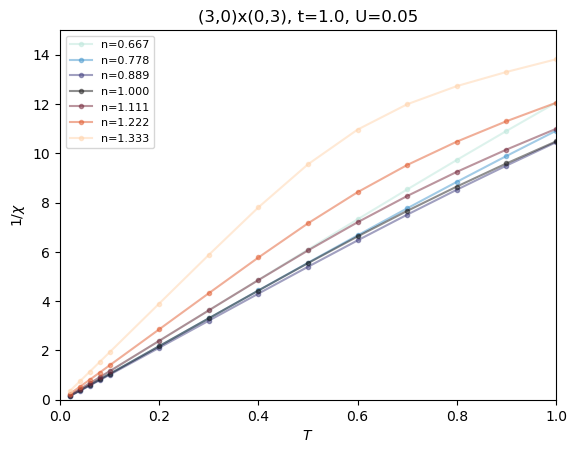

PyObject Text(0.5, 1.0, '(3,0)x(0,3), t=1.0, U=0.05')

In [29]:
temperatures = unique(sort(df[:, :temperature]))
temperatures = [T for T in temperatures]
;

fig = PyPlot.figure()
ax = fig.gca()

# n_list = [5,6,7,8,9,10,11,12,13]
# n_list = [9,10,11,12,13,14,15]
n_list = n_sites-3:n_sites+3

for (idx, n) in enumerate(n_list)
    if n == 0 || n == 18
        continue
    end
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2/T)
        end
    end
    ax.plot(xs, n_sites ./ ys, ".-", label=(@sprintf "n=%.3f" (n/n_sites)),
        color=cmap((idx-1) / (length(n_list)-1)), alpha=0.5)
end
ax.set_xlim(0, 1)
ax.set_ylim(0, 15)
ax.legend(fontsize=8)
ax.set_xlabel(raw"$T$")
ax.set_ylabel(raw"$1/\chi$")
ax.set_title("$(shape_str), t=$t, U=$U")
# fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)

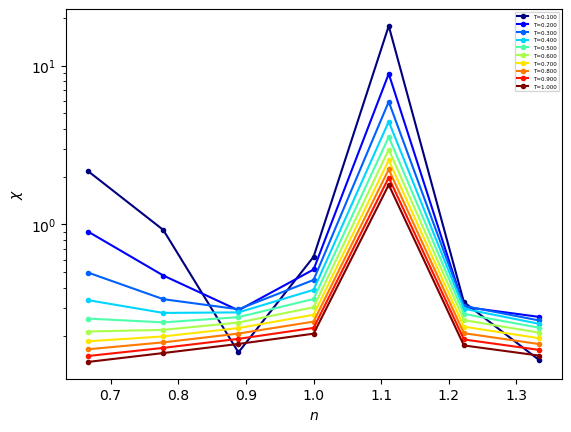

In [16]:
temperatures = unique(sort(df[:, :temperature]))
temperatures = [T for T in temperatures if 0.1 <= T <= 1.0]

fig = PyPlot.figure()
ax = fig.gca()
for T in temperatures
    sdf = df[df[:, :temperature] .== T, :]
    xs = Float64[]
    ys = Float64[]
    for n in n_list
        ssdf = sdf[sdf[:, :nup] .+ sdf[:, :ndn] .== n, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, n)
            push!(ys, corr - Sz_avg^2/T)
        end
    end
#     ax.plot(xs, 1 ./ ys, ".-", label=(@sprintf "n=%.3f" (n/9)))
    ax.plot(xs ./ n_sites, ys ./ n_sites, ".-",
        label=(@sprintf "T=%.3f" T),
        color=mpl.cm.jet( (T - minimum(temperatures)) / (maximum(temperatures) - minimum(temperatures))
    ))
end
# ax.set_xlim(0, nothing)
# ax.set_ylim(0, 1)
ax.legend(fontsize=4)
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$\chi$")
ax.set_yscale("log")

In [84]:
@. model(x, p) = (x - p[2]) / p[1]

model (generic function with 1 method)

In [85]:
temperatures = unique(sort(df[:, :temperature]))
fit_temperatures = [T for T in temperatures if 0.7 <= T <= 5.5]

49-element Vector{Float64}:
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 1.3
 1.4
 1.5
 1.6
 1.7
 1.8
 1.9
 ⋮
 4.4
 4.5
 4.6
 4.7
 4.8
 4.9
 5.0
 5.1
 5.2
 5.3
 5.4
 5.5

Matrix{PyObject} (alias for Array{PyObject, 2})

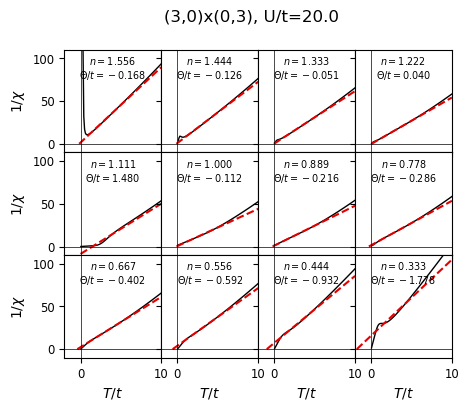

In [222]:
fig = PyPlot.figure(figsize=(5, 4))
axs = fig.subplots(3, 4, sharex=true, sharey=true)
axs = [axs[i,j] for i in 1:3 for j in 1:4]

fig.subplots_adjust(hspace=0, wspace=0)

axs[9].set_xlabel(raw"$T/t$")
axs[10].set_xlabel(raw"$T/t$")
axs[11].set_xlabel(raw"$T/t$")
axs[12].set_xlabel(raw"$T/t$")

axs[1].set_ylabel(raw"$1/\chi$")
axs[5].set_ylabel(raw"$1/\chi$")
axs[9].set_ylabel(raw"$1/\chi$")

fit_params = []
for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (0.8 .<= xs .<= 5.5)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    ax = axs[idx]
    # ax = fig.add_subplot(3, 4, idx, sharex=ax0, sharey=ax0)
    ax.plot(xs, ys, linewidth=1, color="black")
    xfit = [min(f.param[2], 0.0), maximum(xs)] 
    # ax.plot([f.param[2], maximum(xs)], model([f.param[2], maximum(xs)], f.param), linestyle="--", color="xkcd:red")
    ax.plot(xfit, model(xfit, f.param), linestyle="--", color="xkcd:red")

    ax.set_ylim(-10, 110)
    ax.set_xlim(-2, 10)
    ax.text(0.5, 0.95, (@sprintf "\$n=%.3f\$\n\$\\Theta/t=%.3f\$" (n/n_sites) (f.param[2])), ha="center", va="top", transform=ax.transAxes, fontsize="x-small")
#     ax.text(0.5, 0.95, (@sprintf "n=%.3f" (n/n_sites)), ha="center", va="top", transform=ax.transAxes, fontsize="small")
#     ax.set_title("n=$n")
    ax.axhline(0, linewidth=0.5, color="black")
    ax.axvline(0, linewidth=0.5, color="black")
    #ax.set_xscale("log")
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)
fig.suptitle("$(shape_str), U/t=$(U/t)")
fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")
fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).png", dpi=300, bbox_inches="tight")


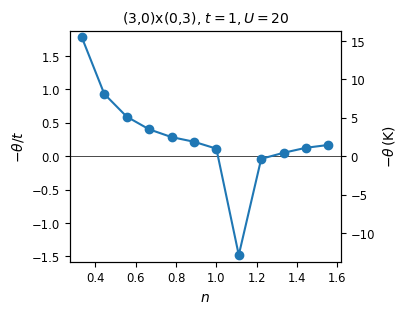

In [221]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
ax2 = ax.twinx()
xs = fit_params[1, :] ./ n_sites
ys = -fit_params[2, :]
ax.plot(xs, ys, "o-")
ax.axhline(0, linewidth=0.5, color="black", zorder=-10)

ymin, ymax = minimum(ys)-0.1, maximum(ys) + 0.1
ax.set_ylim(ymin, ymax)
ax2.set_ylim(ymin * 8.7, ymax*8.7)
ax.set_title("$shape_str, \$t=1, U=20\$")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\theta/t$")
ax2.set_ylabel(raw"$-\theta\,\mathrm{(K)}$")
fig.savefig("weiss-$(shape_str)_fit_to_jieshan.png", dpi=300, bbox_inches="tight")
fig.savefig("weiss-$(shape_str)_fit_to_jieshan.pdf", dpi=300, bbox_inches="tight")


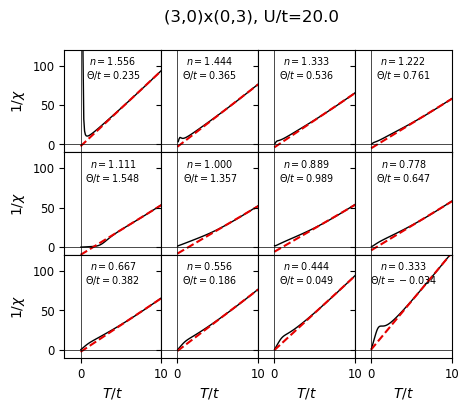

PyObject Text(0.5, 0.98, '(3,0)x(0,3), U/t=20.0')

In [225]:
fig = PyPlot.figure(figsize=(5, 4))
axs = fig.subplots(3, 4, sharex=true, sharey=true)
axs = [axs[i,j] for i in 1:3 for j in 1:4]

fig.subplots_adjust(hspace=0, wspace=0)

axs[9].set_xlabel(raw"$T/t$")
axs[10].set_xlabel(raw"$T/t$")
axs[11].set_xlabel(raw"$T/t$")
axs[12].set_xlabel(raw"$T/t$")

axs[1].set_ylabel(raw"$1/\chi$")
axs[5].set_ylabel(raw"$1/\chi$")
axs[9].set_ylabel(raw"$1/\chi$")

fit_params = []
for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (5 .<= xs)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    ax = axs[idx]
    # ax = fig.add_subplot(3, 4, idx, sharex=ax0, sharey=ax0)
    ax.plot(xs, ys, linewidth=1, color="black")
    xfit = [min(f.param[2], 0.0), maximum(xs)] 
    # ax.plot([f.param[2], maximum(xs)], model([f.param[2], maximum(xs)], f.param), linestyle="--", color="xkcd:red")
    ax.plot(xfit, model(xfit, f.param), linestyle="--", color="xkcd:red")

    ax.set_ylim(-10, 120)
    ax.set_xlim(-2, 10)
    ax.text(0.5, 0.95, (@sprintf "\$n=%.3f\$\n\$\\Theta/t=%.3f\$" (n/n_sites) (f.param[2])), ha="center", va="top", transform=ax.transAxes, fontsize="x-small")
#     ax.text(0.5, 0.95, (@sprintf "n=%.3f" (n/n_sites)), ha="center", va="top", transform=ax.transAxes, fontsize="small")
#     ax.set_title("n=$n")
    ax.axhline(0, linewidth=0.5, color="black")
    ax.axvline(0, linewidth=0.5, color="black")
    #ax.set_xscale("log")
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)
fig.suptitle("$(shape_str), U/t=$(U/t)")
# fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")
# fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).png", dpi=300, bbox_inches="tight")


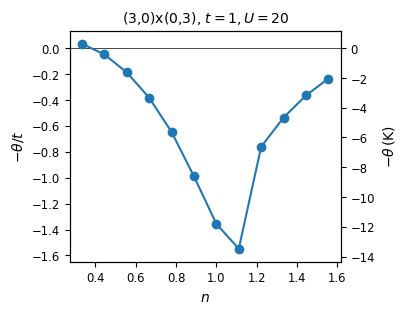

PyObject Text(380.55555555555554, 0.5, '$-\\theta\\,\\mathrm{(K)}$')

In [224]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
ax2 = ax.twinx()
xs = fit_params[1, :] ./ n_sites
ys = -fit_params[2, :]
ax.plot(xs, ys, "o-")
ax.axhline(0, linewidth=0.5, color="black", zorder=-10)

ymin, ymax = minimum(ys)-0.1, maximum(ys) + 0.1
ax.set_ylim(ymin, ymax)
ax2.set_ylim(ymin * 8.7, ymax*8.7)
ax.set_title("$shape_str, \$t=1, U=20\$")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\theta/t$")
ax2.set_ylabel(raw"$-\theta\,\mathrm{(K)}$")
# fig.savefig("weiss-$(shape_str)_fit_to_jieshan.png", dpi=300, bbox_inches="tight")
# fig.savefig("weiss-$(shape_str)_fit_to_jieshan.pdf", dpi=300, bbox_inches="tight")


In [ ]:
# fig = PyPlot.figure(figsize=(4, 6))
# ax0 = fig.add_subplot(4,2,1)

# fit_params = []
# for (idx, n) in enumerate(n_list)
#     xs = Float64[]
#     ys = Float64[]
#     sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
#     for T in fit_temperatures
#         ssdf = sdf[sdf[:, :temperature] .== T, :]
#         if isempty(ssdf)
#             continue
#         end
#         corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
#         if !isnan(corr)
#             push!(xs, T)
#             push!(ys, n_sites / corr)
#         end
#     end
#     f = curve_fit(model, xs, ys, [1.0, 0.0])
#     ax = fig.add_subplot(4, 2,idx, sharex=ax0, sharey=ax0)
#     ax.plot(xs, ys)
#     #ax.plot([0, maximum(xs)], model([0, maximum(xs)], f.param), "--")
#     #ax.plot([1E-2, maximum(xs)], model([1E-2, maximum(xs)], f.param), "--")
#     #ax.plot([-0.2,xs...], model([-0.2,xs...], f.param), "--")
#     ax.plot([f.param[2], maximum(xs)], model([f.param[2], maximum(xs)], f.param), "--")
#     ax.axhline(0, linewidth=0.5, color="black")
#     ax.axvline(0, linewidth=0.5, color="black")
#     #ax.set_xscale("log")
# #     push!(fit_params, [n, f.param[2]] )
# end
# ax0.set_xlim(-1,2)
# ax0.set_ylim(-10,20)